# Projection on vertical modes

This notebook contains instruction for computing mean strat and corresponding vertical modes, and then project fields onto this basis. It is written to deal with cos/sin harmonics fields but the method is general.

N.B.: in this case, linear EOS with Tcoef=1, hence $\rho=T$

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr
import crocosi.postp as pp
from crocosi.gridop import get_z, N2Profile
import crocosi.gridop as gp
from crocosi.vmodes import get_vmodes

/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8788')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:53609 Dashboard: http://127.0.0.1:8788/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


# Read netcdf file

In [7]:
root_path = '/home/datawork-lops-osi/aponte/bturb_itide/jet/'
run = 'jet_cfg1_wp6_4km_nodecay_2000a2300j/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=[], grid_params=gparams, verbose=True)

### fixing a few stuff. WARNING quick & dirty
# time is nan
r['his'].coords['mytime'] = xr.DataArray(np.arange(r['his']["time"].size), dims=["time"])

#r['his']

Analysing directory /home/datawork-lops-osi/aponte/bturb_itide/jet/jet_cfg1_wp6_4km_nodecay_2000a2300j/
Found 3 segments
Found 12 his files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected y_itide = 400000.0 m
Detected jet_ywidth = 800000.0 m
Detected jet_weight = 0.6
Detected omega = 0.000145444104333 1/s
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his']
Grid size: (L ,M, N) = (258, 722, 50)


# Compute mean stratification

**ssh temporal mean**

<xarray.DataArray 'ssh_a' (y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(722, 258), dtype=float32, chunksize=(722, 258), chunktype=numpy.ndarray>
Coordinates:
    xi_w     (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_w    (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_rho  (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho   (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    f        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


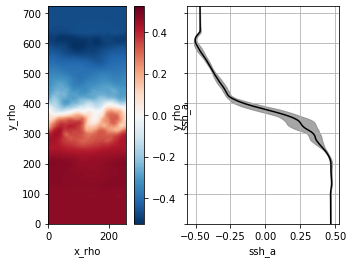

In [8]:
# eventually should also average along x
sshmean = r['his'].ssh_a.mean(dim='time').persist()
print(sshmean)

fig, axs = plt.subplots(1, 2, sharey=True)
hmoy = sshmean.mean(dim="x_rho")
hstd = sshmean.std(dim="x_rho")
sshmean.plot(ax=axs[0])
sshmean.mean(dim="x_rho").plot(ax=axs[1], y="y_rho", color="k")
axs[1].fill_betweenx(r.ds['his'].y_rho, hmoy-hstd, hmoy+hstd, color="grey", alpha=.7)

axs[1].grid(True)
axs[0].set_aspect('equal')

**Compute z mean from ssh mean**

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])
/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py:3239: UserWarning: Large object of size 74.51 MB detected in task graph: 
  (array([[[-9.51529614e-01, -8.61530923e-01, -7.800 ... 4e', 0, 0, 0)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinate

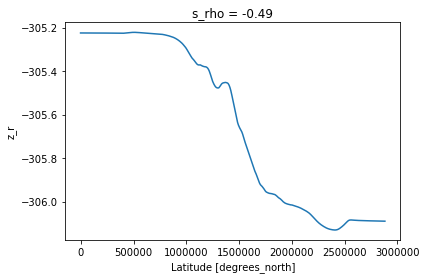

In [9]:
zmean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='r', hgrid='r').persist()
zwean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='w', hgrid='r').persist()
#zmean.isel(x_rho=125).plot(x='y_rho', y='s_rho')
zmean.isel(x_rho=125).sel(s_rho=-.5, method='nearest').plot(x='eta_rho')

**Interpolate vertically stratification T(x,y,z,t)  on zmean -> T(x,y,$\bar{z}$,t)**

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:106: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(z.dims[0], z.dims[3], z.dims[1], z.dims[2])


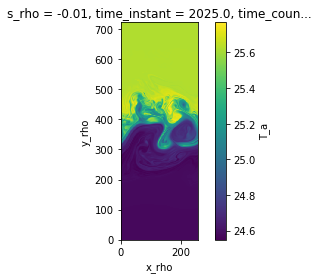

In [10]:
p = r['his'].T_a.isel(time=0,s_rho=-1).plot()
p.axes.set_aspect('equal')

### compute/lazy-load z and T
z = get_z(r, zeta=r['his'].ssh_a, h=r['his'].h, vgrid='r', hgrid='r')
T = r['his'].T_a.chunk({'s_rho':None})

In [11]:
### this should be in gridop -- also, interp3d_fast would benefit from a bit of doc

def interp2z_3d(z0, z, v, b_extrap=2, t_extrap=2):
    """
    b_extrap, t_extrap:
        0 set to NaN
        1 set to nearest neighboor
        2 linear extrapolation
    """
    import crocosi.fast_interp3D as fi  # OpenMP accelerated C based interpolator
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # add dimensions if necessary
    if v.ndim == 1:
        lv = v.squeeze()[:,None,None]
        lz = z.squeeze()[:,None,None]
    elif v.ndim == 2:
        lv = v[...,None]
        lz = z[...,None]
    else:
        lz = z[...]
        lv = v[...]
    #
    return fi.interp(z0.astype('float64'), lz.astype('float64'), lv.astype('float64'), 
                     b_extrap, t_extrap).squeeze()

def interp2z(z0, z, v, b_extrap, t_extrap):
    ''' interpolate vertically
    '''
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # test if temporal dimension is present
    if v.ndim == 4:
        vi = [interp2z_3d(z0, z[...,t], v[...,t], b_extrap, t_extrap)[...,None] 
                  for t in range(v.shape[-1])]
        return np.concatenate(vi, axis=0) # (50, 722, 258, 1)
        #return v*0 + v.shape[3]
    else:
        return interp2z_3d(z0, z, v, b_extrap, t_extrap)


<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258, time: 12)>
dask.array<interp2z, shape=(50, 722, 258, 12), dtype=float64, chunksize=(50, 722, 258, 1), chunktype=numpy.ndarray>
Coordinates:
    xi_w          (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    eta_w         (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    eta_rho       (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho        (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    f             (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    time_instant  (time) float64 2.025e+03 2.05e+03 ... 2.275e+03 2.3e+03
    time_counter  (time) float64 2.012e+03 2.038e+03 ... 2.262e+03 2.288e+03
    mytime        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    z_rho         (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>
Dimensions without co

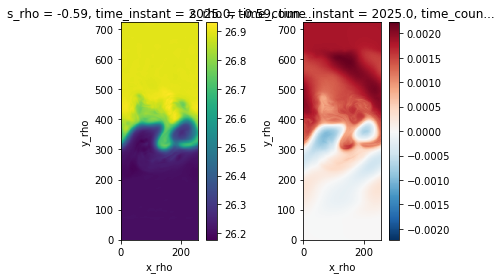

In [12]:
### interpolate T on mean z-grid
Ti = xr.apply_ufunc(interp2z, zmean, z, T, 2, 2,
                    dask='parallelized', output_dtypes=[np.float64])
Ti = Ti.assign_coords(z_rho=zmean)
print(Ti)

ax = plt.subplot(1,2,1)
Ti.isel(time=0, s_rho=20).plot(ax=ax)
ax.set_aspect('equal')
#
ax = plt.subplot(1,2,2)
(T-Ti).isel(time=0, s_rho=20).plot(ax=ax)
ax.set_aspect('equal')

**Temporal mean of stratification T(x,y,$\bar{z}$,t) -> T(x,y,$\bar{z}$)**

<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(50, 722, 258), dtype=float64, chunksize=(50, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    xi_w     (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    eta_w    (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    eta_rho  (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho   (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    f        (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


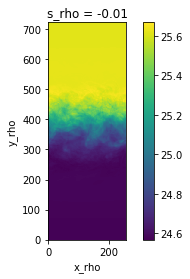

In [13]:
Tmean = Ti.mean(dim='time')
print(Tmean)
p = Tmean.isel(s_rho=-1).plot()
p.axes.set_aspect('equal')

**Compute N2 profile from stratification on mean z  T(x,y,$\bar{z}$) -> N2(x,y,$\bar{z}$)**

<xarray.DataArray (s_w: 51, y_rho: 722, x_rho: 258)>
dask.array<truediv, shape=(51, 722, 258), dtype=float64, chunksize=(49, 722, 258), chunktype=numpy.ndarray>
Dimensions without coordinates: s_w, y_rho, x_rho


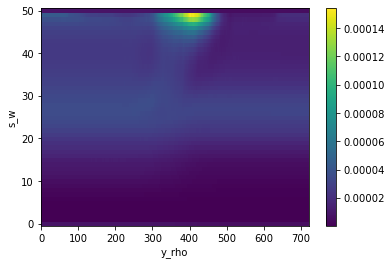

In [14]:
N2 = N2Profile(r,Tmean,zmean).persist()
print(N2)
p = N2.mean(dim="x_rho").plot()
#p.axes.set_aspect('equal')

**Compute vertical modes N2(x,y,$\bar{z}$) -> $\phi_{n}$(x,y,$\bar{z}$)**

Use compute_vmodes function and wrapper for using with dask/xarray


compute_vmodes 10
CPU times: user 272 ms, sys: 16 ms, total: 288 ms
Wall time: 365 ms
CPU times: user 740 ms, sys: 104 ms, total: 844 ms
Wall time: 5.26 s


<xarray.Dataset>
Dimensions:  (mode: 11, s_rho: 50, s_w: 51, x_rho: 1, y_rho: 722)
Coordinates:
    xi_w     (y_rho, x_rho) float32 -2000.0 -2000.0 -2000.0 ... -2000.0 -2000.0
    eta_w    (y_rho, x_rho) float32 -2000.0 2000.0 ... 2878000.0 2882000.0
    eta_rho  (y_rho, x_rho) float32 -2000.0 2000.0 ... 2878000.0 2882000.0
    xi_rho   (y_rho, x_rho) float32 -2000.0 -2000.0 -2000.0 ... -2000.0 -2000.0
    f        (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 1), meta=np.ndarray>
    z_w      (s_w, y_rho, x_rho) float64 dask.array<chunksize=(51, 722, 1), meta=np.ndarray>
Dimensions without coordinates: s_w, x_rho, y_rho
Data variables:
    c        (mode, y_rho, x_rho) float64 dask.array<chunksize=(11, 722, 1), meta=np.ndarray>
    phi      (mode, s_rho, y_rho, x_rho) float64

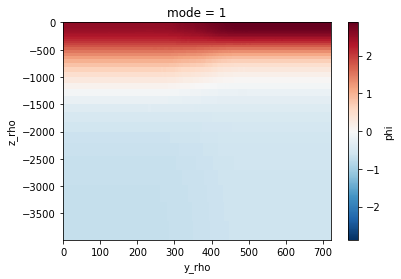

In [15]:
# compute mode on a y slice: that works fine

%time ds = get_vmodes(zmean.isel(x_rho=[0]), zwean.isel(x_rho=[0]), N2.isel(x_rho=[0]))

%time ds.phi.sel(mode=1).plot(x="y_rho", y="z_rho")

ds

In [13]:
import scipy.sparse as sp
import scipy.sparse.linalg as la
import numpy as np
import xarray as xr

### default values
_g = 9.81
_sig = .1
_nmodes = 10

def get_vmodes(zc, zf, N2, nmodes=_nmodes, **kwargs):
    """ wrapper for calling compute_vmodes with apply_ufunc. Includes unstacking of result
    this is what you should need in your scripts, unless you are using numpy arrays only 
    input:
        - zc: z-levels at center of cells
        - zf: z-levels at cell faces
        - N2: BVF at cell faces 
        - nmodes (default:10): number of vertical modes (+ barotropic)
    z levels must be in ascending order (first element is at bottom, last element is at surface)
    output: xarray dataset with phase speed, pressure-modes (at center) and w-modes (at faces)
    kwargs:
        - free_surf (bool): use free surface boundary condition (default:True)
        - sigma (scalar or None): for shift-invert in eig (default: 0.1)
    """
    # unpack kwargs
    kwargs = kwargs.copy().update({"nmodes":nmodes, "stacked":True})
        
    N = zc.s_rho.size
    res = xr.apply_ufunc(compute_vmodes, zc.chunk({"s_rho":-1}), zf.chunk({"s_w":-1}), \
                    N2.chunk({"s_w":-1}), kwargs=kwargs, input_core_dims=[["s_rho"],["s_w"],["s_w"]], \
                    dask='parallelized', output_dtypes=[np.float64], \
                    output_core_dims=[["s_stack","mode"]], \
                    output_sizes={"mode":nmodes+1,"s_stack":2*(N+1)})
    res['mode'] = np.arange(nmodes+1)
    c = res.isel(s_stack=0).rename('c')
    phi = (res.isel(s_stack=slice(1,N+1))
           .rename('phi').rename({'s_stack': 's_rho'})
           .assign_coords(z_rho=zc))
    dphidz = (res.isel(s_stack=slice(N+1,2*N+2))
              .rename('dphidz').rename({'s_stack': 's_w'})
              .assign_coords(z_w=zf))
    #return c, phi, dphidz
    return xr.merge([c, phi, dphidz])#.transpose('mode','s_rho','s_w','y_rho','x_rho')

def compute_vmodes(zc_nd, zf_nd, N2f_nd, nmodes=_nmodes, free_surf=True, g=_g, sigma=_sig, stacked=True):
    """
    wrapper for vectorizing compute_vmodes_1D over elements of axes other than vertical dim
    that's not elegant, nor efficient
    here z is last axis (because it is core dim)
    you can use this if you are using numpy (but make sure z is last dim)
    """
    assert zc_nd.ndim==zf_nd.ndim==N2f_nd.ndim
    assert zf_nd.shape==N2f_nd.shape
    if zc_nd.ndim>1:
        nxy = zc_nd.shape[:-1]
        nn = np.prod(nxy)
        zc_nd = zc_nd.reshape(nn,zc_nd.shape[-1])
        zf_nd = zf_nd.reshape(nn,zf_nd.shape[-1])
        N2f_nd = N2f_nd.reshape(nn,N2f_nd.shape[-1])
        ii = 0
        cn, phin, dphi = compute_vmodes_1D(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma)
        cn, phin, dphi = cn[None,:], phin[None,...], dphi[None,...]
        for ii in range(1,nn):
            res = compute_vmodes_1D(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma)
            cn = np.vstack([cn, res[0][None,...]])
            phin = np.vstack([phin,res[1][None,...]])
            dphi = np.vstack([dphi,res[2][None,...]])
        if stacked:
            return np.hstack([cn[:,None,:],phin,dphi]).reshape(nxy+(-1,nmodes+1))
        else:
            return cn.reshape(nxy+(nmodes,)), phin.reshape(nxy+(-1,nmodes)), \
                        dphi.reshape(nxy+(-1,nmodes))
    else:
        return compute_vmodes_1D(zc_nd, zf_nd, N2f_nd, nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma)

            
def compute_vmodes_1D(zc, zf, N2f, nmodes=_nmodes, free_surf=True, g=_g, sigma=_sig):
    """ compute vertical modes: solution of SL problem (phi'/N^2)'+k*phi=0'
    returns phi at rho points, dphi at w points and c=1/sqrt(k) 
    normalization such that int(phi^2)=H, w-modes=d(phi)/dz
    copy-pasted from M. Dunphy's vmodes_MD.py"""
    # Precompute a few quantities
    assert zc.ndim==zf.ndim==N2f.ndim==1
    assert len(zc)+1==len(N2f)==len(zf)
    dzc=np.diff(zc)
    dzf=np.diff(zf)
    Np=len(zf) #self.zf)
    N20=N2f[-1] #self.N2f[-1]  # N^2(z=0)
    H = abs(zf[0])
    
    # Build Dz, C-to-F grid 
    v1=-1.0/np.concatenate([dzc,np.ones(1)])
    v2= 1.0/np.concatenate([np.ones(1),dzc])
    v12=np.stack([v1, v2])
    Dz=sp.spdiags(v12,[-1, 0],Np,Np-1,format="lil")
    # Adjust matrix for BCs
    Dz[0,:]=0
    Dz[-1,:]=0
    if free_surf:
        Dz[-1,-1]=np.divide(-N20, g + N20*(zf[-1] - zc[-1]))

    # Build Dz2, F-to-C grid
    v1=-1.0/np.concatenate([dzf,np.ones(1)])
    v2= 1.0/np.concatenate([np.ones(1),dzf])
    v12=np.stack([v1,v2])
    Dz2=sp.spdiags(v12,[0, 1],Np-1,Np,format="lil")
    
    # Construct A, solve eigenvalue problem
    iN2=sp.spdiags(1.0/N2f,0,Np,Np)
    A=-Dz2*iN2*Dz
    ev,ef = la.eigs(A.tocsc(),nmodes+1,sigma=sigma)
    ev,ef = np.real(ev), np.real(ef)
    
    # Convert eigvenvalues to c_e, sort appropriately
    c=1.0/np.sqrt(np.real(ev))
    ii=(-c).argsort()
    c=c[ii]               # c_e value
    phic=ef[:,ii]         # phi at cell centres

    # Normalize and set surface value positive
    for mi in range(nmodes+1):
        fn=phic[:,mi]        # current phi
        s=np.sign(fn[-1])         # sign at surface
        if s==0:
            s=1;
        tmp = np.sum((fn**2)*dzf)/H
        phic[:,mi] = s*fn/np.sqrt(tmp) # (1/H)*\int_{-H}^{0} \phi_m(z)^2 dz = 1
        
    # dphi at cell faces: phi'=dphidz (buoyancy modes)
    dphif = Dz*phic
    # this would give w-modes: np.r_[np.zeros((1,nmodes+1)),(dzf[:,None]*phic).cumsum(axis=0)]
    return c, phic, dphif


In [26]:
### weird thing: if you try to rerun the computation changing the chunk size, you have errors 
# of e.g. when merging, reshaping, or xi_rho does not match...
### TODO check that it works with line chunks
### TODO try with squared chunk vs. lines (may need to recompute the whole thing, see above)
Nx, Ny = r['his'].dims['x_rho'], r['his'].dims['y_rho']
slix, sliy = slice(Nx), slice(Ny)
nchx, nchy = 40, 40
%time ds = get_vmodes(zmean.isel(x_rho=slix,y_rho=sliy).chunk({"x_rho":nchx,"y_rho":nchy}), \
                      zwean.isel(x_rho=slix,y_rho=sliy).chunk({"x_rho":nchx,"y_rho":nchy}), \
                      N2.isel(x_rho=slix,y_rho=sliy).chunk({"x_rho":nchx,"y_rho":nchy})).persist()

#%time c.sel(mode=1).plot(x="x_rho", y="y_rho")

CPU times: user 31.1 s, sys: 768 ms, total: 31.9 s
Wall time: 32.5 s


In [25]:
r['his'].dims['x_rho']

258

CPU times: user 9.74 s, sys: 1.06 s, total: 10.8 s
Wall time: 1min 28s


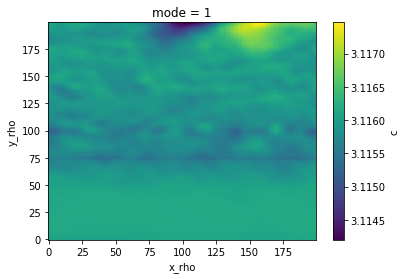

In [15]:
%time ds.c.sel(mode=1).plot(x="x_rho", y="y_rho")

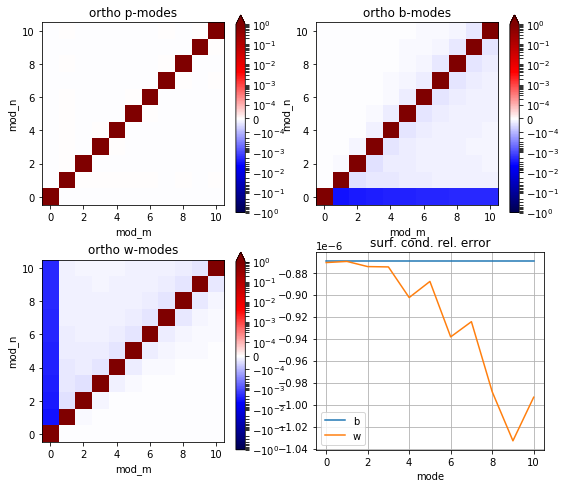

In [16]:
### check orthogonality and free surf condition -- buoy modes
# the small error in w is probably due to mismatch at the surf of integrated phi
fig, axs = plt.subplots(2, 2, figsize=(9,8))
axs = axs.ravel()

grid = r['his'].attrs['xgcm-Grid']
sds = ds.isel(x_rho=0, y_rho=0).persist()
modn = sds.phi.rename({'mode':'mod_n'})
modm = sds.phi.rename({'mode':'mod_m'})
orthomat = (grid.diff(sds.z_w, "s")*modn*modm).sum("s_rho")/r["his"].h.mean()
orthomat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[0])
axs[0].set_title('ortho p-modes')

grav = 9.81
# buoyancy modes, = d phi / dz
mobn = sds.dphidz.rename({'mode':'mod_n'})
mobm = sds.dphidz.rename({'mode':'mod_m'})
orthobat = (mobn*mobm/N2.isel(y_rho=0,x_rho=0)).integrate(dim="z_w") \
            + grav* mobn.isel(s_w=-1)*mobm.isel(s_w=-1)/N2.isel(y_rho=0,x_rho=0,s_w=-1)**2 
            #+ modn.isel(s_rho=-1)*modm.isel(s_rho=-1)/grav
orthobat *= sds.c.rename({'mode':'mod_n'})**2/r['his'].h.mean()
orthobat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[1])
axs[1].set_title('ortho b-modes')

# w modes, = int(phi)
mown = grid.cumsum(grid.diff(sds.z_w, "s")*sds.phi, "s", to="outer", boundary="fill")
mown = mown.assign_coords(z_w=sds.z_w).rename({"mode":"mod_n"})
mowm = mown.rename({"mod_n":"mod_m"})
orthowat = (mown*mowm*N2.isel(y_rho=0,x_rho=0)).integrate(dim="z_w") \
            + grav* mown.isel(s_w=-1)*mowm.isel(s_w=-1)
orthowat /= sds.c.rename({'mode':'mod_n'})**2*r['his'].h.mean()
orthowat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[2])
axs[2].set_title('ortho w-modes')

# check free surface condition : w(0) = c²/g p(0)
ax = axs[3]
relerb = 1 + N2.isel(x_rho=0,y_rho=0,s_w=-1)*sds.phi.isel(s_rho=-1)/grav/sds.dphidz.isel(s_w=-1)
relerb.plot(ax=ax, label="b")
relerw = 1 - sds.phi.isel(s_rho=-1)*sds.c**2/grav/mown.isel(s_w=-1).rename({'mod_n':'mode'})
relerw.plot(ax=ax, label='w')
ax.set_title('surf. cond. rel. error')
ax.grid(True)
ax.ticklabel_format(style='sci',scilimits=(-2,3))
ax.legend()

for ax in axs[:3]:
    ax.set_aspect('equal')
    
fig.subplots_adjust(wspace=.2)

**Don't go there unless you want to get stuck**

In [22]:
### get vmodes in a new dataset: take forever
%time ds = get_vmodes(zmean, zwean, N2).persist()
ds

CPU times: user 212 ms, sys: 24 ms, total: 236 ms
Wall time: 352 ms


<xarray.Dataset>
Dimensions:  (mode: 11, s_rho: 50, s_w: 51, x_rho: 258, y_rho: 722)
Coordinates:
    xi_rho   (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    xi_w     (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    eta_rho  (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    eta_w    (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    f        (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>
    z_w      (s_w, y_rho, x_rho) float64 dask.array<chunksize=(51, 722, 258), meta=np.ndarray>
Dimensions without coordinates: s_w, x_rho, y_rho
Data variables:
    c        (mode, y_rho, x_rho) float64 dask.array<chunksize=(11, 722, 258), meta=np.ndarray>
    phi      (mode, s_rho, y_rho, x_rho) float64

In [ ]:
fig, axs = plt.subplots(1, 2)

%time p = ds.c.sel(mode=1).plot(x='xi_rho',y='eta_rho', ax=axs[0])
p.axes.set_aspect('equal')
%time ds.phi.isel(x_rho=0, mode=1).plot.contourf(x='eta_rho', y='z_rho', levels=20, axis=axs[1])

# Projection of a variable on vertical modes

**Interpolation of the variable on zmean -> var(x,y,$\bar{z}$,t)**

this is still ongoing work

In [14]:
# define get_p (not sure this is correct)
# it would be nice to be able to interpolate from w-grid to r-grid (e.g. get rid of broadcasting)
# I think p is wrong for now

def get_p_zmoy(ds, zr, zw, rho, zrho=None):
    _g = 9.81
    grid = ds.attrs['xgcm-Grid']
    if zrho is not None:
        rho = xr.apply_ufunc(interp2z, zr, zrho, rho, False, \
                    dask='parallelized', output_dtypes=[np.float64])
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    pres = pres - pres.isel(s_w=-1) # how to get cumsum going the other way ?
    return grid.interp(pres, "s")

def get_p(r, ds, rho, zeta, z=None):
    """ this is the baroclinic pressure, without rho0*zeta and int(rho0) """
    # this is a bit wrong, because variable boundary for integration of rho makes pressure nonlinear
    
    _g = 9.81
    zw = get_z(r, zeta, h=ds.h, vgrid='w', hgrid='r')
    grid = ds.attrs['xgcm-Grid']
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    if z is None:
        return grid.interp(pres, "s")
    else:
        return xr.apply_ufunc(interp2z, z, zw.chunk({'s_w':-1}), pres.chunk({'s_w':-1}), False, \
                    input_core_dims=[['s_rho'],['s_w'],['s_w'],[]], output_core_dims=[['s_rho']], \
                    dask='parallelized', output_dtypes=[np.float64])


In [15]:
# project p, u and v
### not using interpolated field because can't extrapolate, hence nan                                        

ds = r['his']
grid = ds.attrs['xgcm-Grid']
dz = grid.diff(zf, "s")
hwean = np.abs(zwean.isel(s_w=-1)-zwean.isel(s_w=0))

### first pressure
#pp = get_p(r, ds, ds.T_t_cos, ds.ssh_t_cos)
pp = get_p_zmoy(ds, zmean, zwean, ds.T_t_cos, z)
pn = (dz*pp*phin).sum("s_rho")/hwean

### then x-velocity
ur = grid.interp(ds.u_t_cos, "xi").rename({'y_u':'y_rho'}) # question: does grid.interp know how to broadcast?
#ur = xr.apply_ufunc(interp2z, zmean, z, ur, True, 
#                    dask='parallelized', output_dtypes=[np.float64])
un = (dz*ur*phin).sum("s_rho")/hwean

### then y-velocity
vv = r['his'].v_t_cos
vr = grid.interp(vv, "eta").rename({'x_v':'x_rho'})
vn = (dz*vr*phin).sum("s_rho")/hwean


NameError: name 'zf' is not defined

In [17]:
ds.T_t_cos.isel(time=0,x_rho=jj).plot()

NameError: name 'jj' is not defined

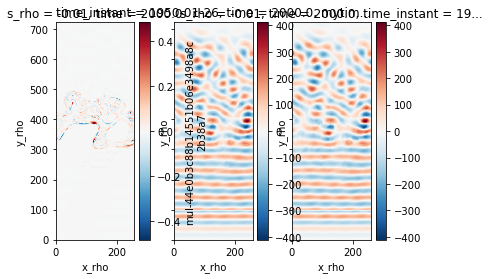

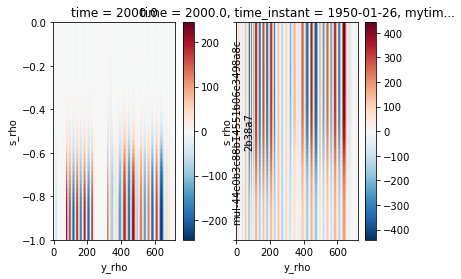

In [72]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

psurf = pp.isel(s_rho=-1).isel(time=0)
etap = (ds.ssh_t_cos*(r.params['rho0']+T.isel(s_rho=-1))*9.81).isel(time=0)

psurf.plot(ax=axs[0])
etap.plot(ax=axs[1])
(psurf+etap).plot(ax=axs[2])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
psec = pp.isel(x_rho=jj).isel(time=0)
ptot = psec + etap.isel(x_rho=jj)
psec.plot(ax=axs[0])
pbcl.plot(ax=axs[1])

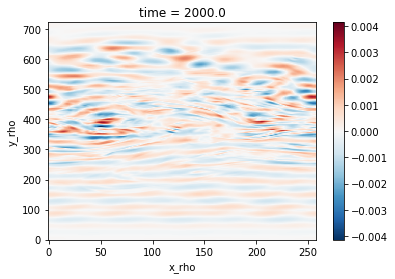

In [127]:
un.isel(time=0,modes=0).plot(x="x_rho")

In [17]:
### u2rho returns " KeyError: 'X' "
uu = r['his'].u_t_cos.isel(x_u=[jj,jj+1]).mean("x_u")

ui = xr.apply_ufunc(interp2z, zmean, z, uu, False, 
                    dask='parallelized', output_dtypes=[np.float64])

### I need to switch dim from "s_w" to "s_rho" for dz
### same for u, v -> need u2rho, v2rho and have xarray understand y_u = y_rho
un = (zwean.diff('s_w')*ui*phin).sum("s_rho")

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16.3 ms
